In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pathlib import Path
import ee
from loguru import logger

In [2]:
ee.Initialize()

S2_COLLECTION = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate(
    "2020-01-01", "2020-12-31"
)

In [13]:
def load_data():
    # get all index files
    index_files = glob.glob(
        "../../data/gee_pipeline/outputs/s2_indices_per_mgrs_tile/s2-indices_2020_*.txt"
    )

    # filter out all the files that that are empty
    index_files = [f for f in index_files if Path(f).stat().st_size > 0]

    # create a list of dataframes
    dfs = [pd.read_table(f, header=None) for f in index_files]

    # concatenate all dataframes into a single dataframe
    df = pd.concat(dfs)
    df.columns = ["system:index"]
    df["tile"] = df["system:index"].str.split("_").str[2]
    df["date"] = df["system:index"].str.split("_").str[0]

    # filter all dates in 2020
    df = df[df["date"].str.contains("2020")]
    df["tile"] = df["tile"].str[1:]

    print(f"Number of images: {df.shape[0]}")
    # sample one row per tile
    df = df.drop_duplicates(subset=["tile"])

    return df

In [14]:
def compute_features(fc):
    fc_computed = ee.data.computeFeatures({"expression": fc})

    total_features_retrieved = len(fc_computed.get("features", {}))
    if total_features_retrieved == 0:
        logger.error(f"Empty feature collection; after grouping.")
    if "nextPageToken" in fc_computed:
        logger.debug(
            f"Partial retrieval of {total_features_retrieved} features. Fetching the rest."
        )
        fc_list = [fc_computed]
        while "nextPageToken" in fc_computed:
            fc_computed = ee.data.computeFeatures(
                {"expression": fc, "pageToken": fc_computed["nextPageToken"]}
            )
            fc_list.append(fc_computed)
            total_features_retrieved += len(fc_computed["features"])
            logger.debug(
                f"Partial retrieval of {total_features_retrieved} features. Fetching the rest."
            )
        logger.debug(f"Total features retrieved: {total_features_retrieved}")
        fc_concat = {
            "type": "FeatureCollection",
            "features": [feature for fc in fc_list for feature in fc["features"]],
        }
    else:
        logger.debug(f"Total features retrieved: {total_features_retrieved}")
        fc_concat = fc_computed

    return fc_concat

In [15]:
def get_s2_lat_lon_from_system_indices(list_indices: list[str]) -> pd.DataFrame:
    # convert list of system indices to a list of ee.List
    list_indices = ee.List(list_indices)

    # filter s2 collection by list of system indices
    s2_imgc = S2_COLLECTION.filter(ee.Filter.inList("system:index", list_indices))

    # get the centroid and return as feature collection
    s2_imgc_centroid = s2_imgc.map(
        lambda img: ee.Feature(
            None, {"centroid": img.geometry().centroid(), "date": img.date()}
        )
    )

    # compute the features
    # s2_imgc_centroid_computed = ee.data.computeFeatures(
    #     {"expression": s2_imgc_centroid}
    # )

    s2_imgc_centroid_computed = compute_features(s2_imgc_centroid)

    # get the features
    features = s2_imgc_centroid_computed.get("features", {})
    if len(features) == 0:
        logger.error("Empty feature collection")
        return pd.DataFrame()

    # convert feature collection to pandas dataframe using geojson format
    features = [
        feature["properties"]
        for feature in features
        if "properties" in feature
        and "centroid" in feature["properties"]
        and "coordinates" in feature["properties"]["centroid"]
    ]

    df = pd.DataFrame(features)
    df["centroid"] = df["centroid"].apply(lambda x: x["coordinates"])
    df[["lon", "lat"]] = pd.DataFrame(df["centroid"].tolist(), index=df.index)
    df = df.drop(columns=["centroid"])

    return df

In [16]:
df = load_data()

Number of images: 254117


In [17]:
df

,system:index,tile,date
0,20200719T031539_20200719T031541_T56XML,56XML,20200719T031539
4,20200730T024549_20200730T024548_T56XMH,56XMH,20200730T024549
9,20200911T025549_20200911T025546_T56XMJ,56XMJ,20200911T025549
0,20200111T064229_20200111T064720_T40PBU,40PBU,20200111T064229
8,20200111T064229_20200111T064720_T40PBV,40PBV,20200111T064229
...,...,...,...
464,20200719T172901_20200719T173845_T14TLS,14TLS,20200719T172901
512,20200724T172859_20200724T173118_T14TMQ,14TMQ,20200724T172859
520,20200719T172901_20200719T173845_T14TMR,14TMR,20200719T172901
528,20200719T172901_20200719T173845_T14TMS,14TMS,20200719T172901


In [18]:
system_indices = df["system:index"].tolist()
fc = get_s2_lat_lon_from_system_indices(system_indices)

2025-03-19 13:12:05.181 | DEBUG    | __main__:compute_features:8 - Partial retrieval of 1000 features. Fetching the rest.
2025-03-19 13:12:12.038 | DEBUG    | __main__:compute_features:18 - Partial retrieval of 2000 features. Fetching the rest.
2025-03-19 13:12:19.819 | DEBUG    | __main__:compute_features:18 - Partial retrieval of 3000 features. Fetching the rest.
2025-03-19 13:12:27.029 | DEBUG    | __main__:compute_features:18 - Partial retrieval of 4000 features. Fetching the rest.
2025-03-19 13:12:32.390 | DEBUG    | __main__:compute_features:18 - Partial retrieval of 5000 features. Fetching the rest.
2025-03-19 13:12:37.465 | DEBUG    | __main__:compute_features:18 - Partial retrieval of 6000 features. Fetching the rest.
2025-03-19 13:12:45.385 | DEBUG    | __main__:compute_features:18 - Partial retrieval of 7000 features. Fetching the rest.
2025-03-19 13:12:52.003 | DEBUG    | __main__:compute_features:18 - Partial retrieval of 8000 features. Fetching the rest.
2025-03-19 13:12:

In [20]:
fc

,date,lon,lat
0,"{'type': 'Date', 'value': 1577837943100}",152.444720,-8.612546
1,"{'type': 'Date', 'value': 1577846720478}",117.498580,8.549922
2,"{'type': 'Date', 'value': 1577846716771}",118.369886,8.566409
3,"{'type': 'Date', 'value': 1577849710550}",105.501191,10.358641
4,"{'type': 'Date', 'value': 1577859742305}",51.710122,-46.559258
...,...,...,...
18341,"{'type': 'Date', 'value': 1609337977238}",-59.997842,-25.365747
18342,"{'type': 'Date', 'value': 1609337976408}",-59.972845,-25.320069
18343,"{'type': 'Date', 'value': 1609340662439}",-70.250398,-5.039718
18344,"{'type': 'Date', 'value': 1609340619039}",-69.949023,-2.375324


In [21]:
# convert date to datetime // date column: {'type': 'Date', 'value': 1577988254772}
fc["date"] = pd.to_datetime(fc["date"].apply(lambda x: x["value"] / 1000), unit="s")

In [22]:
df = fc

# Plotting - 1
- divide into latitudinal zones
- count per month and latidudinal zone
- create heatmap

In [23]:
df

,date,lon,lat
0,2020-01-01 00:19:03.099999905,152.444720,-8.612546
1,2020-01-01 02:45:20.477999926,117.498580,8.549922
2,2020-01-01 02:45:16.770999908,118.369886,8.566409
3,2020-01-01 03:35:10.549999952,105.501191,10.358641
4,2020-01-01 06:22:22.305000067,51.710122,-46.559258
...,...,...,...
18341,2020-12-30 14:19:37.237999916,-59.997842,-25.365747
18342,2020-12-30 14:19:36.407999992,-59.972845,-25.320069
18343,2020-12-30 15:04:22.438999891,-70.250398,-5.039718
18344,2020-12-30 15:03:39.039000034,-69.949023,-2.375324


In [24]:
# create month
df["month"] = df["date"].dt.month

In [25]:
# Simulate latitudinal zones from -90 to 90 degrees
latitudinal_zones = np.arange(-60, 90, 10)  # 10-degree steps from -90 to +90

# add latitudinal zone to df
df["latitudinal_zone"] = pd.cut(df["lat"], latitudinal_zones)

In [26]:
# count per month and latitudinal zone
tiles_count = df.groupby(["month", "latitudinal_zone"]).size().reset_index(name="count")

/var/folders/v0/b73t62hd08z_gd18bqxybmt80000gn/T/ipykernel_62445/4032353644.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tiles_count = df.groupby(["month", "latitudinal_zone"]).size().reset_index(name="count")


In [27]:
tiles_count

,month,latitudinal_zone,count
0,1,"(-60, -50]",6
1,1,"(-50, -40]",4
2,1,"(-40, -30]",34
3,1,"(-30, -20]",87
4,1,"(-20, -10]",53
...,...,...,...
163,12,"(30, 40]",75
164,12,"(40, 50]",50
165,12,"(50, 60]",22
166,12,"(60, 70]",0


In [28]:
# normalize counts to proportions per latidudinal zone

tiles_count["proportion"] = tiles_count.groupby("latitudinal_zone")["count"].transform(
    lambda x: x / x.sum()
)

# replace NANs in proportion column with 0
tiles_count["proportion"] = tiles_count["proportion"].fillna(0)

/var/folders/v0/b73t62hd08z_gd18bqxybmt80000gn/T/ipykernel_62445/806737040.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tiles_count["proportion"] = tiles_count.groupby("latitudinal_zone")["count"].transform(


In [29]:
tiles_count

,month,latitudinal_zone,count,proportion
0,1,"(-60, -50]",6,0.096774
1,1,"(-50, -40]",4,0.021390
2,1,"(-40, -30]",34,0.059130
3,1,"(-30, -20]",87,0.075850
4,1,"(-20, -10]",53,0.040582
...,...,...,...,...
163,12,"(30, 40]",75,0.038780
164,12,"(40, 50]",50,0.024876
165,12,"(50, 60]",22,0.010461
166,12,"(60, 70]",0,0.000000


In [30]:
# Pivot for heatmap
heatmap_data = tiles_count.pivot(
    index="latitudinal_zone", columns="month", values="proportion"
)

# reverse order of latitudinal zones
heatmap_data = heatmap_data.iloc[::-1]

# remove latitudinal zone above 80 degrees north
heatmap_data

month,1,2,3,4,5,6,7,8,9,10,11,12
latitudinal_zone,,,,,,,,,,,,
"(70, 80]",0.000000,0.000000,0.005442,0.019048,0.054422,0.070748,0.435374,0.331973,0.072109,0.010884,0.000000,0.000000
"(60, 70]",0.000542,0.001084,0.001084,0.002710,0.013550,0.102981,0.383198,0.398374,0.078591,0.017886,0.000000,0.000000
"(50, 60]",0.003329,0.000951,0.004755,0.008084,0.055159,0.201617,0.251070,0.339515,0.109368,0.010461,0.005231,0.010461
"(40, 50]",0.039303,0.043781,0.014428,0.048259,0.138308,0.113433,0.221891,0.187562,0.133333,0.017413,0.017413,0.024876
"(30, 40]",0.135471,0.068769,0.061013,0.094105,0.130817,0.041365,0.070321,0.207342,0.110134,0.025853,0.016029,0.038780
"(20, 30]",0.191053,0.108947,0.118947,0.032632,0.047895,0.014211,0.009474,0.070000,0.101053,0.160526,0.097368,0.047895
"(10, 20]",0.066624,0.049327,0.039078,0.021140,0.030109,0.008328,0.017297,0.065983,0.257527,0.190263,0.151185,0.103139
"(0, 10]",0.172312,0.042710,0.036819,0.049337,0.112666,0.079529,0.063328,0.081001,0.098675,0.147275,0.059647,0.056701
"(-10, 0]",0.095745,0.072473,0.088431,0.119016,0.152926,0.189495,0.101729,0.079122,0.017287,0.019282,0.015293,0.049202


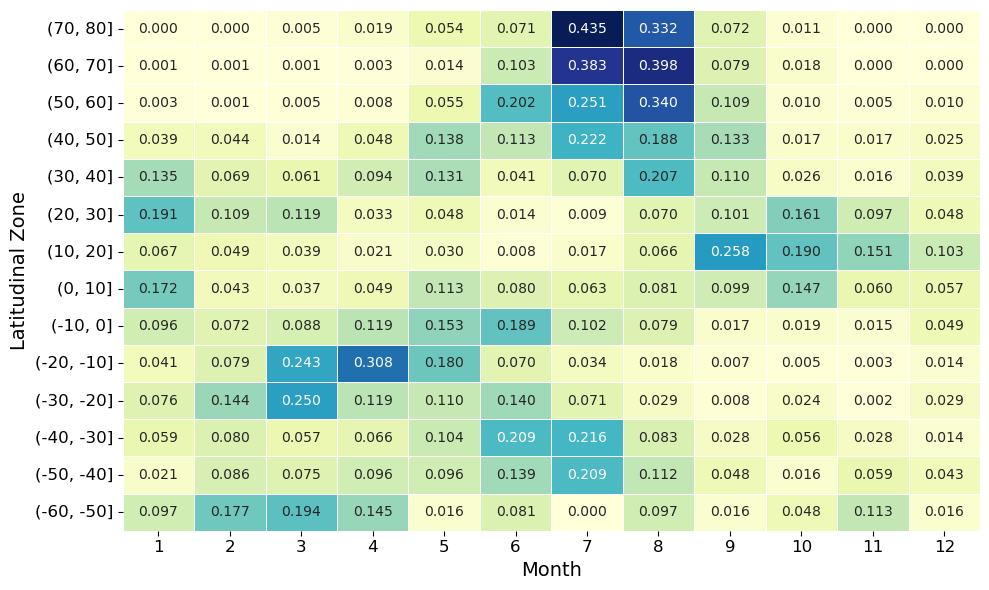

In [31]:
# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data, cmap="YlGnBu", annot=True, fmt=".3f", linewidths=0.5, cbar=False
)
# plt.title("Heatmap of Proportions by Month and Latitudinal Zone")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Latitudinal Zone", fontsize=14)


# publication quality - increased font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
# plt.show()

# save plot as vector graphics (svg or pdf)
plt.savefig("heatmap_proportions_month_latitudinal_zone.png", format="png", dpi=300)